In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as curve_fit
from scipy.optimize import minimize as minimize
from uncertainties import ufloat
from uncertainties import unumpy
from uncertainties.unumpy import nominal_values as nv
from uncertainties.unumpy import std_devs as sd
from uncertainties.umath import *
from scipy.odr import Model,RealData,ODR
from functools import partial
%matplotlib notebook

# 7. Aluminum background

In [2]:
albg_t_s = ufloat(3545,1)
albg_N = ufloat(1000,sqrt(1000))
albg_I = albg_N/albg_t_s
albg_I

0.2820874471086037+/-0.008920743227486653

In [3]:
sqrt(1000)/3545

0.008920388322054667

# 2. Effective range of electrons

## Data preparation

In [4]:
eff_range = pd.read_csv('2_Eff_range.csv')
eff_range = eff_range.sort_values("d_mm")
erange_N = unumpy.uarray(eff_range.N,np.sqrt(eff_range.N))
erange_t = unumpy.uarray(eff_range.t_s,np.ones(eff_range.t_s.shape[0]))
erange_d = unumpy.uarray(eff_range.d_mm,eff_range.dd_mm)
erange_I = erange_N/erange_t-albg_I
erange_N,erange_t,erange_d,erange_I

(array([8943.0+/-94.56743625582752, 4784.0+/-69.16646586316233,
        3167.0+/-56.27610505356603, 2354.0+/-48.518037882832814,
        2191.0+/-46.8081189538738, 1780.0+/-42.190046219457976,
        1275.0+/-35.70714214271425, 1071.0+/-32.72613634390714,
        836.0+/-28.91366458960192, 1081.0+/-32.87856444554719,
        1006.0+/-31.71750305430741, 1002.0+/-31.654383582688826,
        1004.0+/-31.68595903550972], dtype=object),
 array([60.0+/-1.0, 60.0+/-1.0, 60.0+/-1.0, 60.0+/-1.0, 60.0+/-1.0,
        60.0+/-1.0, 60.0+/-1.0, 60.0+/-1.0, 60.0+/-1.0, 92.0+/-1.0,
        122.0+/-1.0, 540.0+/-1.0, 990.0+/-1.0], dtype=object),
 array([0.0+/-0.005, 0.1+/-0.01, 0.2+/-0.01, 0.3+/-0.01, 0.35+/-0.01,
        0.4+/-0.01, 0.55+/-0.02, 0.65+/-0.01, 0.75+/-0.03, 0.83+/-0.05,
        1.1+/-0.05, 2.1+/-0.05, 3.1+/-0.05], dtype=object),
 array([148.7679125528914+/-2.9419942681970297,
        79.45124588622473+/-1.759236808266859,
        52.50124588622473+/-1.2859677251601447,
        38.95124588

In [5]:
unumpy.nominal_values(erange_I)

array([148.76791255,  79.45124589,  52.50124589,  38.95124589,
        36.23457922,  29.38457922,  20.96791255,  17.56791255,
        13.65124589,  11.46791255,   7.96381419,   1.57346811,
         0.73205397])

## Empirical values

$$\rho R_{eff} (g/cm^2) = [0.54 E_{max} (MeV) - 0.13], \quad\quad\quad E_{max}>0.8MeV$$
$$\rho R_{eff} (g/cm^2) = 0.41 E_{max}^{1.38} (MeV), \quad\quad 0.15MeV<E_{max}<0.8MeV$$

In [6]:
rho = 2.7
d_Y = (0.54*2.29-0.13)*10/2.7
d_Sr = 0.41*(0.546**1.38)*10/2.7
print(f"Theoretical range ({d_Sr:.2f},{d_Y:.2f})mm")

Theoretical range (0.66,4.10)mm


### Fitting weighted sum of two exponentials using odr fit

In [7]:
decay = lambda x,A,t: A*np.exp(x*t)
double_decay = lambda B,x: decay(x,B[0],B[1])+decay(x,B[2],B[3])
ddmodel = Model(double_decay)
mydata = RealData(nv(erange_d),nv(erange_I),sx=sd(erange_d),sy=sd(erange_I))
myodr = ODR(mydata,ddmodel,beta0=[nv(erange_I).max()/2,-1,nv(erange_I).max()/2,-1])
output = myodr.run()
output.pprint()
# for par in ddmodel.param_names:
# ddmodel.set_param_hint("A1",min = 0)
# ddmodel.set_param_hint("A2",min = 0)
# ddmodel.set_param_hint("t1",max = 0)
# ddmodel.set_param_hint("t2",max = 0)
# ddresult = ddmodel.fit(unumpy.nominal_values(erange_I),x=eff_range.d_mm,A1=unumpy.nominal_values(erange_I).max()/2,
#                        A2=unumpy.nominal_values(erange_I).max()/2,t1=-1,t2=-1,weights=1/unumpy.std_devs(erange_I))
# fig = plt.figure()
# fig, gridspec = ddresult.plot(fig=fig,yerr=unumpy.std_devs(erange_I))
# # fig.get_axes()[1].set_yscale("log")
# # fig.get_axes()[0].set_yscale("log")
# fig.suptitle("Weighted fit")
# print(str.format(ddresult.fit_report()))

Beta: [ 36.59260492  -1.35103544 107.03213942  -6.54914791]
Beta Std Error: [5.23347942 0.08485514 9.9690909  0.83696851]
Beta Covariance: [[ 5.88760835e+00 -8.31291480e-02 -3.93598235e+00 -7.64237626e-01]
 [-8.31291480e-02  1.54779779e-03  6.11983242e-02  9.53155581e-03]
 [-3.93598235e+00  6.11983242e-02  2.13633317e+01 -8.11072711e-02]
 [-7.64237626e-01  9.53155581e-03 -8.11072711e-02  1.50583057e-01]]
Residual Variance: 4.652025948561534
Inverse Condition #: 0.027568864814672057
Reason(s) for Halting:
  Sum of squares convergence


In [8]:
best_fit = lambda x: double_decay(output.beta,x)

In [9]:
output.beta,output.sd_beta

(array([ 36.59260492,  -1.35103544, 107.03213942,  -6.54914791]),
 array([5.23347942, 0.08485514, 9.9690909 , 0.83696851]))

<IPython.core.display.Javascript object>


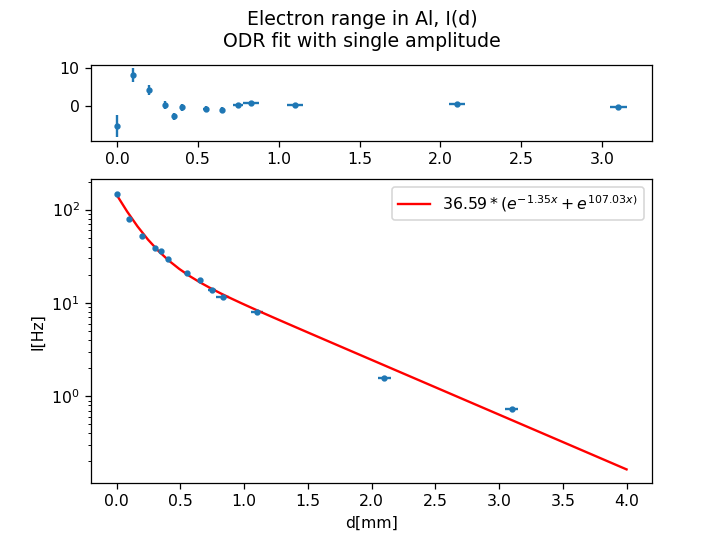

In [10]:
fig,axes = plt.subplots(2,gridspec_kw={us})
axes[0].errorbar(nv(erange_d),best_fit(nv(erange_d))-nv(erange_I),yerr=sd(erange_I),xerr=sd(erange_d),fmt='.')
ax = axes[1]
finder = lambda x: (best_fit(x)-nv(erange_I).max()/1000)**2
electron_range = minimize(finder,3)
ax.errorbar(nv(erange_d),nv(erange_I),yerr=sd(erange_I),xerr=sd(erange_d),fmt='.')
smoothx = np.linspace(nv(erange_d)[0],4,50)
ax.plot(smoothx, best_fit(smoothx), 'r-', 
        label=f"${output.beta[0]:.2f}*(e^{{{output.beta[1]:.2f}x}}+e^{{{output.beta[2]:.2f}x)}}$")
# ax.scatter(electron_range.x,best_fit(electron_range.x), label='Electron range in Al, $I=I_0/1000$', color='green')
ax.set_yscale('log')
fig.suptitle("Electron range in Al, I(d)\nODR fit with single amplitude")
ax.set_xlabel('d[mm]')
ax.set_ylabel('I[Hz]')
ax.legend()
# ax.text(3.4,5, f"({electron_range.x[0]:.2f},{best_fit(electron_range.x[0]):.2f})")

In [11]:
print(output.cov_beta)

[[ 5.88760835e+00 -8.31291480e-02 -3.93598235e+00 -7.64237626e-01]
 [-8.31291480e-02  1.54779779e-03  6.11983242e-02  9.53155581e-03]
 [-3.93598235e+00  6.11983242e-02  2.13633317e+01 -8.11072711e-02]
 [-7.64237626e-01  9.53155581e-03 -8.11072711e-02  1.50583057e-01]]


In [12]:
print(-np.log(1/1000)/ufloat(output.beta[1],output.sd_beta[1]))
print(-np.log(1/1000)/ufloat(output.beta[2],output.sd_beta[2]))

-5.11+/-0.32
0.065+/-0.006


## Single amplitude + constant (background)

In [13]:
decay = lambda x,A,t: A*np.exp(x*t)
double_decay = lambda B,x: decay(x,B[0],B[1])+decay(x,B[0],B[2])
ddmodel = Model(double_decay)
mydata = RealData(nv(erange_d),nv(erange_I),sx=sd(erange_d),sy=sd(erange_I))
myodr = ODR(mydata,ddmodel,beta0=[nv(erange_I).max()/2,-1,-1])
output = myodr.run()
output.pprint()

Beta: [ 60.38569973  -1.69405681 -10.84865605]
Beta Std Error: [5.45304068 0.11464948 4.46210796]
Beta Covariance: [[ 1.88279601e+00 -2.75574683e-02 -9.53042138e-01]
 [-2.75574683e-02  8.32280966e-04  8.88934862e-03]
 [-9.53042138e-01  8.88934862e-03  1.26068313e+00]]
Residual Variance: 15.793347990723072
Inverse Condition #: 0.009476744055049616
Reason(s) for Halting:
  Sum of squares convergence


In [14]:
print(-np.log(1/1000)/ufloat(output.beta[1],output.sd_beta[1]))
print(-np.log(1/1000)/ufloat(output.beta[2],output.sd_beta[2]))

-4.08+/-0.28
-0.64+/-0.26


In [15]:
best_fit = lambda x: double_decay(output.beta,x)

In [16]:
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_resy = fig.add_subplot(gs[0, 0], sharex=ax)
ax_resx = fig.add_subplot(gs[1, 1], sharey=ax)
ax_resy.errorbar(nv(erange_d),output.eps,yerr=sd(erange_I),xerr=sd(erange_d),fmt='.')
ax_resy.set_ylabel('Y residuals')
ax_resy.axes.xaxis.set_visible(False)
ax_resx.errorbar(output.delta,nv(erange_I),yerr=sd(erange_I),xerr=sd(erange_d),fmt='.')
ax_resx.set_xlabel('X residuals')
ax_resx.axes.yaxis.set_visible(False)
# ax = axes[1]
ax.errorbar(nv(erange_d),nv(erange_I),yerr=sd(erange_I),xerr=sd(erange_d),fmt='.')
smoothx = np.linspace(-0.1,3.5,50)
ax.plot(smoothx, best_fit(smoothx), 'r-', 
        label=f"${output.beta[0]:.2f}*(e^{{{output.beta[1]:.2f}d}}+e^{{{output.beta[2]:.2f}d)}}$")
ax.set_yscale('log')
fig.text(0.28,0.6,'cov(A,$t_1$,$t_2$) =')
fig.text(0.40,0.55,output.cov_beta)
fig.text(0.38,0.5,f'Residual Variance ($\chi^2_{{2d}}/ndof$) = {output.res_var:.2f}')
fig.suptitle("Electron range in Al, I(d)\nODR fit $I(d;A,t_1,t_2)=A(e^{t_1d}+e^{t_2d})$")
ax.set_xlabel('d[mm]')
ax.set_ylabel('I[Hz]')
ax.legend()

<IPython.core.display.Javascript object>

c:\users\tsrun\.virtualenvs\beta-report-snzlwprn\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Chi2 (residual variance)

In [17]:
output.sum_square

157.93347990723072

In [18]:
np.sum((output.delta/sd(erange_d))**2+(output.eps/sd(erange_I))**2)/(erange_I.shape[0]-3)

15.793347990723074

Chi2 (only in y)

In [19]:
np.sum((output.eps/sd(erange_I))**2)/(erange_I.shape[0]-3)

5.56004505689497

In [20]:
output.beta,output.sd_beta

(array([ 60.38569973,  -1.69405681, -10.84865605]),
 array([5.45304068, 0.11464948, 4.46210796]))

In [21]:
print(np.sqrt(np.diag(output.cov_beta)))

[1.37215014 0.02884928 1.12280147]


In [22]:
np.set_printoptions(precision=2)

In [23]:
with np.printoptions(precision=2, suppress=False):
    print(output.cov_beta)

[[ 1.88e+00 -2.76e-02 -9.53e-01]
 [-2.76e-02  8.32e-04  8.89e-03]
 [-9.53e-01  8.89e-03  1.26e+00]]


In [24]:
ax.text(output.cov_beta,1,2)

Text([[ 1.88e+00 -2.76e-02 -9.53e-01]
 [-2.76e-02  8.32e-04  8.89e-03]
 [-9.53e-01  8.89e-03  1.26e+00]], 1, '2')

## Single amplitude + const (background)

In [25]:
decay = lambda x,A,t: A*np.exp(x*t)
double_decay = lambda B,x: decay(x,B[0],B[1])+decay(x,B[0],B[2])+B[3]
ddmodel = Model(double_decay)
mydata = RealData(nv(erange_d),nv(erange_I),sx=sd(erange_d),sy=sd(erange_I))
myodr = ODR(mydata,ddmodel,beta0=[nv(erange_I).max()/2,-1,-1,0.6])
output = myodr.run()
output.pprint()

Beta: [ 70.78  -2.18 -12.2    0.67]
Beta Std Error: [2.59 0.06 1.87 0.04]
Beta Covariance: [[ 5.55e+00 -1.06e-01 -2.87e+00  2.76e-02]
 [-1.06e-01  3.26e-03  3.89e-02 -1.09e-03]
 [-2.87e+00  3.89e-02  2.91e+00 -8.51e-03]
 [ 2.76e-02 -1.09e-03 -8.51e-03  1.46e-03]]
Residual Variance: 1.2083569188140504
Inverse Condition #: 0.008474999770928493
Reason(s) for Halting:
  Sum of squares convergence


In [26]:
print(-np.log(1/1000)/ufloat(output.beta[1],output.sd_beta[1]))
print(-np.log(1/1000)/ufloat(output.beta[2],output.sd_beta[2]))

-3.17+/-0.09
-0.57+/-0.09


In [27]:
best_fit = lambda x: double_decay(output.beta,x)

<IPython.core.display.Javascript object>


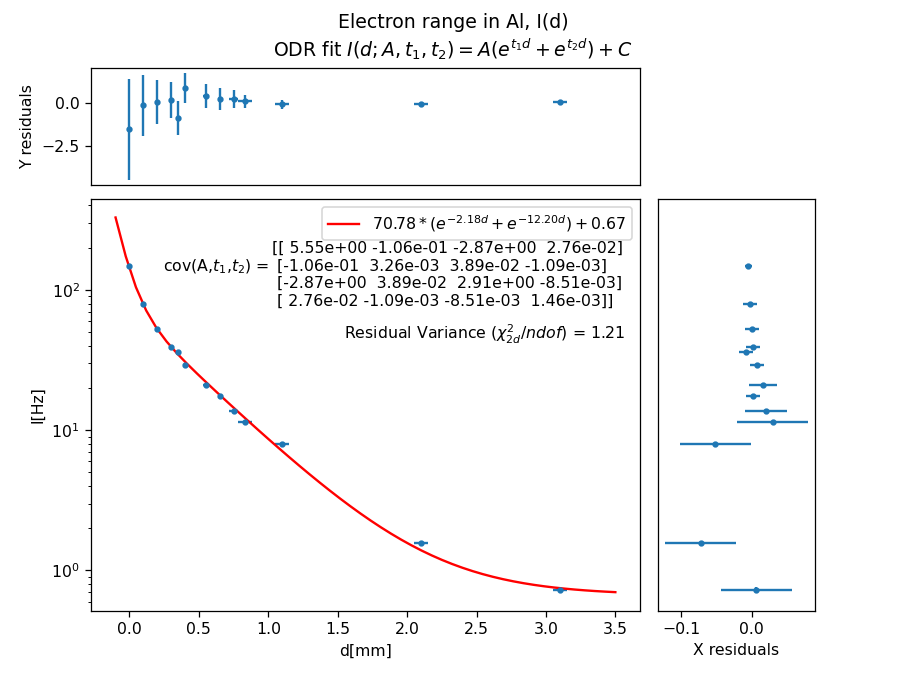

c:\users\tsrun\.virtualenvs\beta-report-snzlwprn\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


In [29]:
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_resy = fig.add_subplot(gs[0, 0], sharex=ax)
ax_resx = fig.add_subplot(gs[1, 1], sharey=ax)
ax_resy.errorbar(nv(erange_d),output.eps,yerr=sd(erange_I),xerr=sd(erange_d),fmt='.')
ax_resy.set_ylabel('Y residuals')
ax_resy.axes.xaxis.set_visible(False)
ax_resx.errorbar(output.delta,nv(erange_I),yerr=sd(erange_I),xerr=sd(erange_d),fmt='.')
ax_resx.set_xlabel('X residuals')
ax_resx.axes.yaxis.set_visible(False)
# ax = axes[1]
ax.errorbar(nv(erange_d),nv(erange_I),yerr=sd(erange_I),xerr=sd(erange_d),fmt='.')
smoothx = np.linspace(-0.1,3.5,50)
ax.plot(smoothx, best_fit(smoothx), 'r-', 
        label=f"${output.beta[0]:.2f}*(e^{{{output.beta[1]:.2f}d}}+e^{{{output.beta[2]:.2f}d}})+{output.beta[3]:.2f}$")
ax.set_yscale('log')
fig.text(0.18,0.6,'cov(A,$t_1$,$t_2$) =')
fig.text(0.30,0.55,output.cov_beta)
fig.text(0.38,0.5,f'Residual Variance ($\chi^2_{{2d}}/ndof$) = {output.res_var:.2f}')
fig.suptitle("Electron range in Al, I(d)\nODR fit $I(d;A,t_1,t_2)=A(e^{t_1d}+e^{t_2d})+C$")
ax.set_xlabel('d[mm]')
ax.set_ylabel('I[Hz]')
ax.legend()